In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import torch
import torchaudio
import seaborn as sns
import helper_functions


In [155]:
eeg_df= pd.read_csv('eeg_Eye_State_Classification.csv')

print(f"shape: {eeg_df.shape}")

shape: (14980, 15)


In [3]:
print(eeg_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB
None


In [4]:
eeg_df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


## class distribution

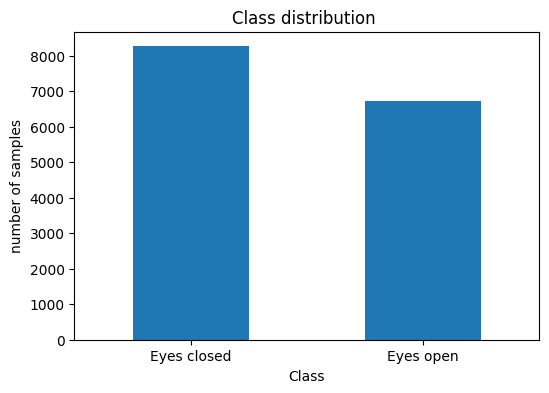

In [5]:
class_counts = eeg_df['eyeDetection'].value_counts()

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("number of samples")
plt.title("Class distribution ")
plt.xticks(ticks=[0, 1], labels=["Eyes closed", "Eyes open"], rotation=0)
plt.show()


## chaneels visualization

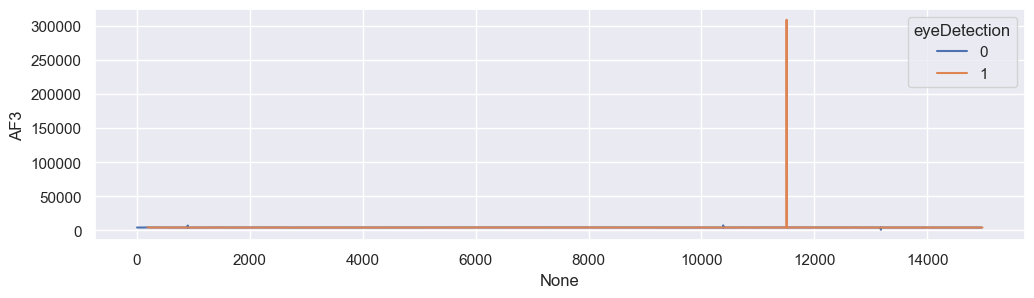

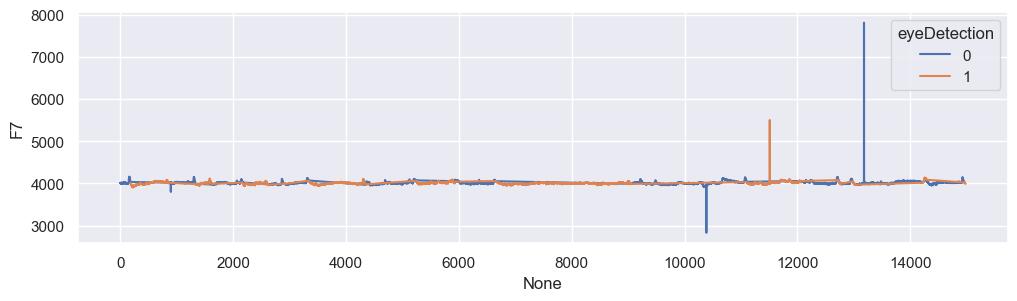

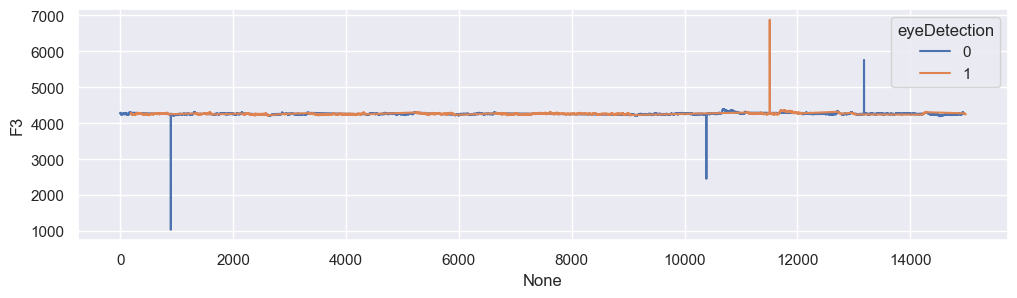

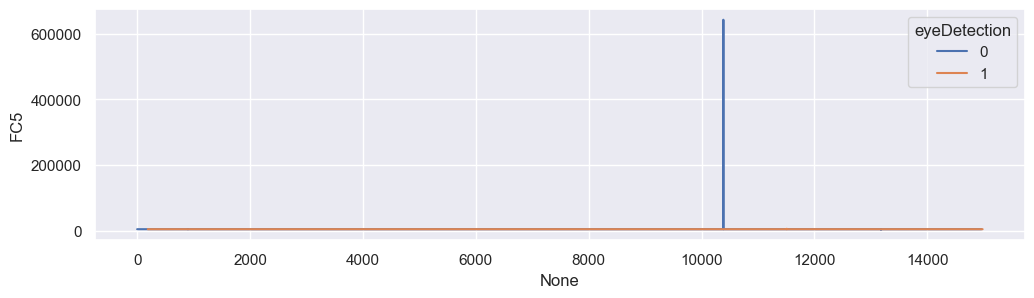

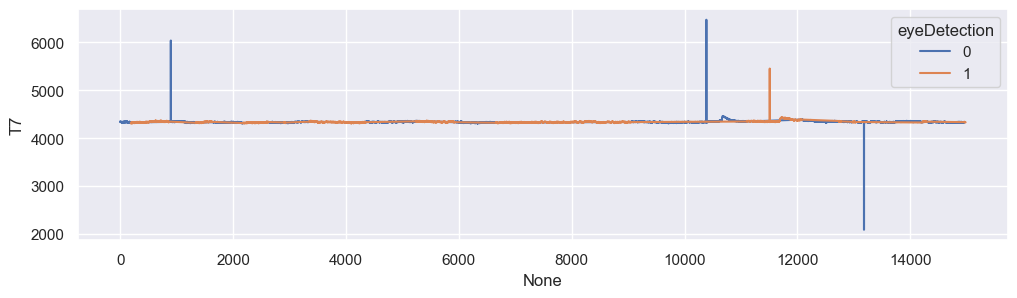

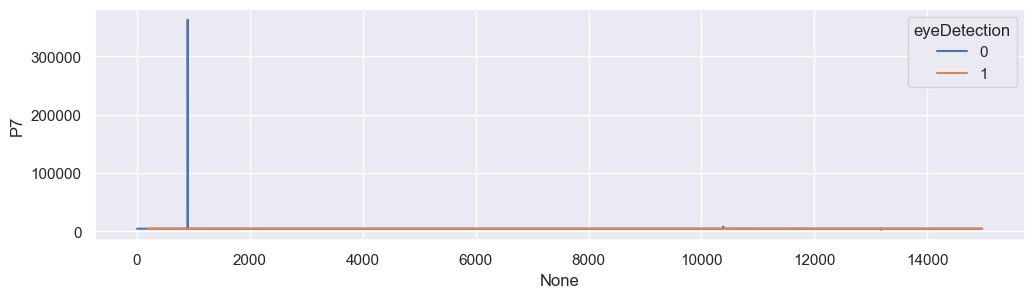

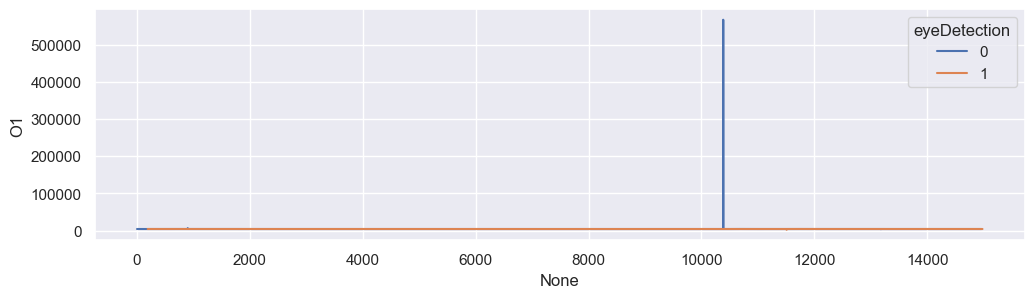

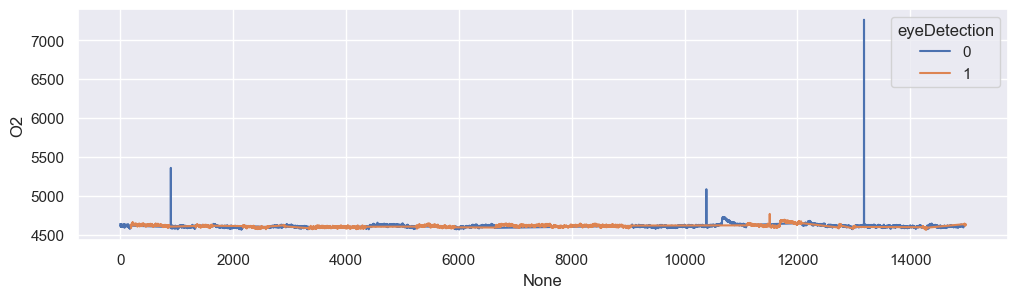

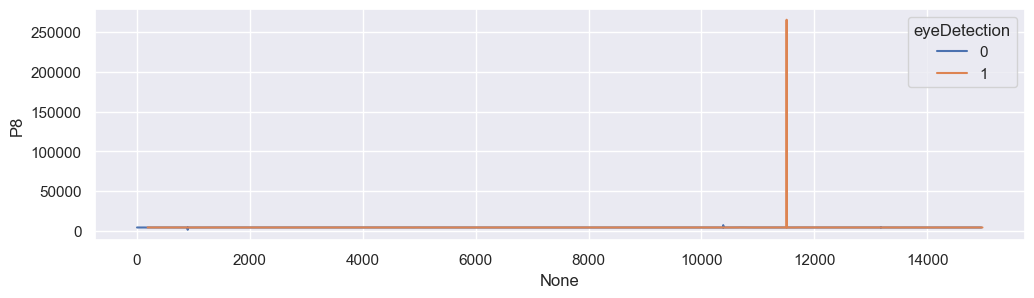

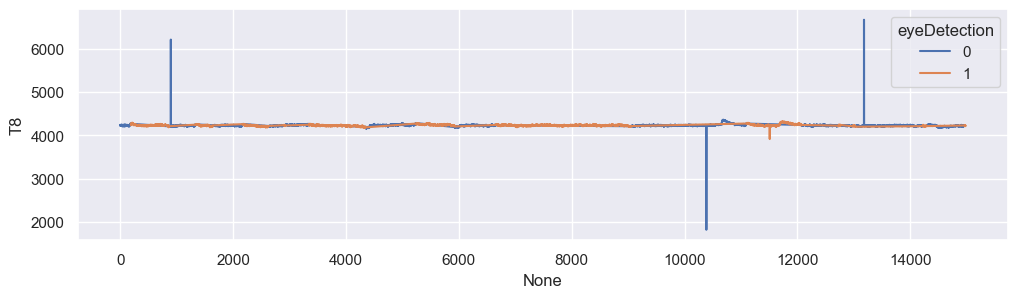

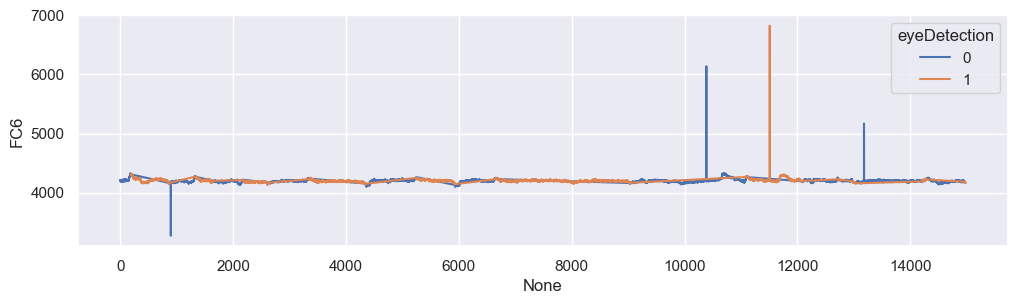

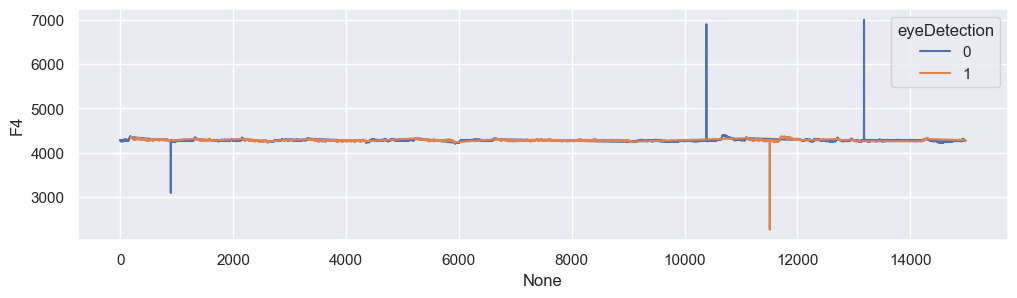

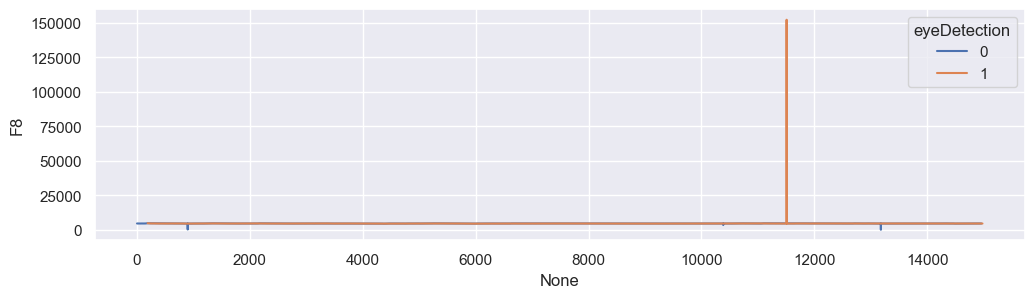

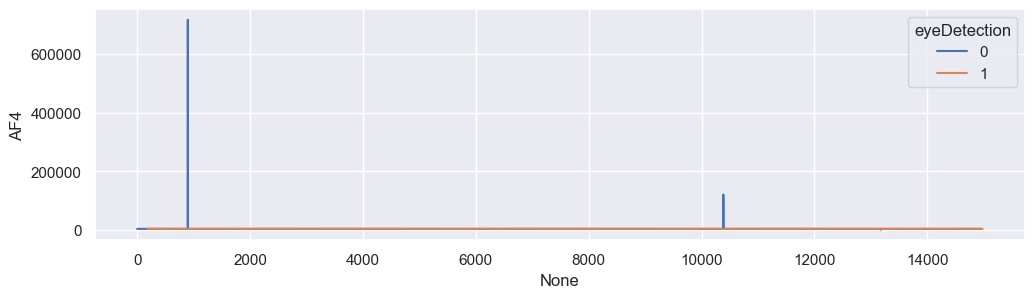

In [6]:
sns.set_theme(style='darkgrid')
for col in eeg_df.columns[0:-1]:
    plt.figure(figsize=(12, 3))
    sns.lineplot(x=eeg_df.index, y=col, data=eeg_df, hue="eyeDetection")
    plt.show()

## eye state visualization

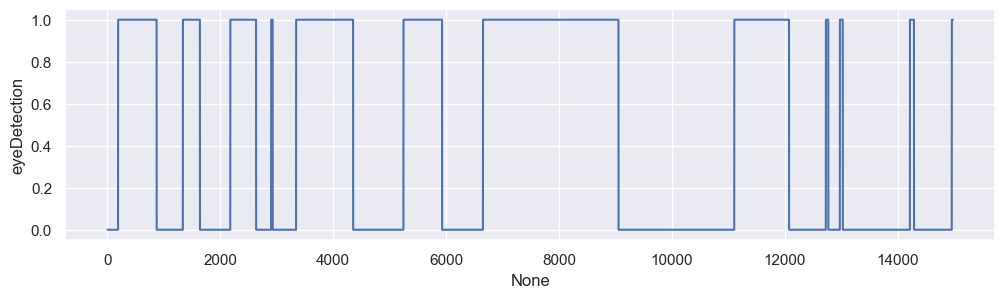

In [7]:
plt.figure(figsize=(12, 3))
sns.lineplot(x=eeg_df.index, y=eeg_df.columns[-1], data=eeg_df)
plt.show()

In [8]:
channels = eeg_df.columns
corr_matrix = eeg_df[channels].corr()


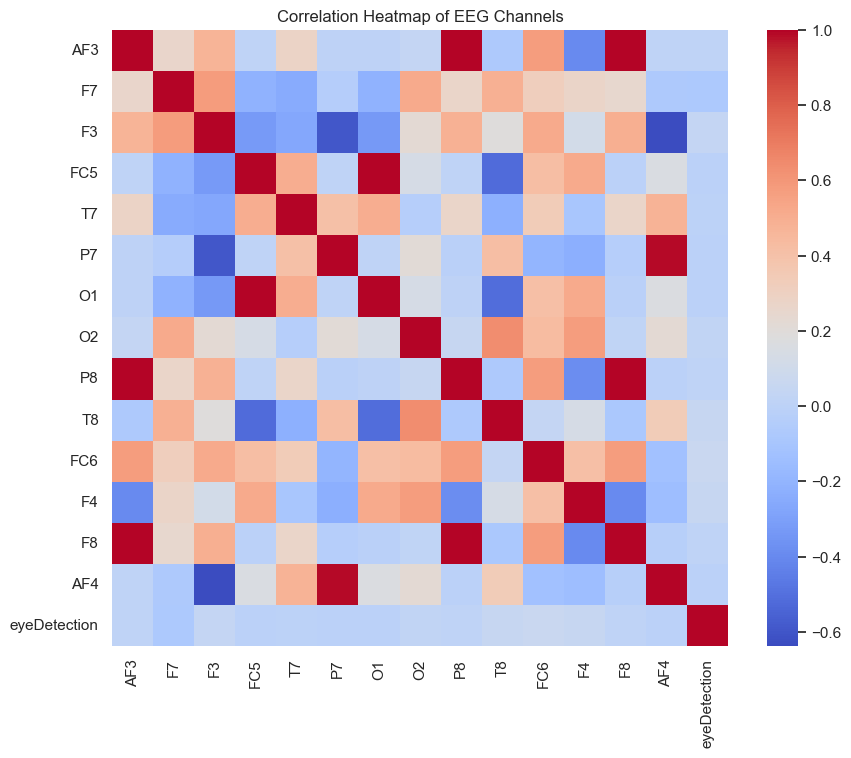

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=False,
    square=True
)
plt.title("Correlation Heatmap of EEG Channels")
plt.show()


## outlier removal


In [156]:
y=eeg_df['eyeDetection']
eeg_df=eeg_df.drop(columns=['eyeDetection'])

In [128]:
eeg_df.shape

(14980, 14)

In [129]:
abs_z_scores= np.abs(scipy.stats.zscore(eeg_df,axis=0))
eeg_df_filtred= eeg_df.copy()
eeg_df_filtred[abs_z_scores>=10]= np.nan
eeg_df_filtred.isna().sum().sum()


np.int64(33)

In [130]:
tras=[3,5,10,15,20,50,100]
for t in tras:
    abs_z_scores= np.abs(scipy.stats.zscore(eeg_df,axis=0))
    eeg_df_filtred= eeg_df.copy()
    eeg_df_filtred[abs_z_scores>=t]= np.nan
    droped_count=eeg_df_filtred.isna().sum().sum()
    print(f'{droped_count} values {t} std far from the mean')


209 values 3 std far from the mean
35 values 5 std far from the mean
33 values 10 std far from the mean
33 values 15 std far from the mean
31 values 20 std far from the mean
20 values 50 std far from the mean
7 values 100 std far from the mean


## using trashold of 10

In [131]:
abs_z_scores= np.abs(scipy.stats.zscore(eeg_df,axis=0))
eeg_df_filtred= eeg_df.copy()
eeg_df_filtred[abs_z_scores>=10]= np.nan
eeg_df_filtred.isna().sum()



AF3    1
F7     3
F3     4
FC5    1
T7     4
P7     1
O1     1
O2     3
P8     1
T8     3
FC6    4
F4     4
F8     1
AF4    2
dtype: int64

## Interpolate missing values using cubic spline interpolation

In [132]:
eeg_df_interp = eeg_df_filtred.interpolate(
    method="spline",
    order=3,
    axis=0,
    limit_direction="both"
)


In [133]:
sfreq = 128
t = np.arange(len(eeg_df)) / sfreq

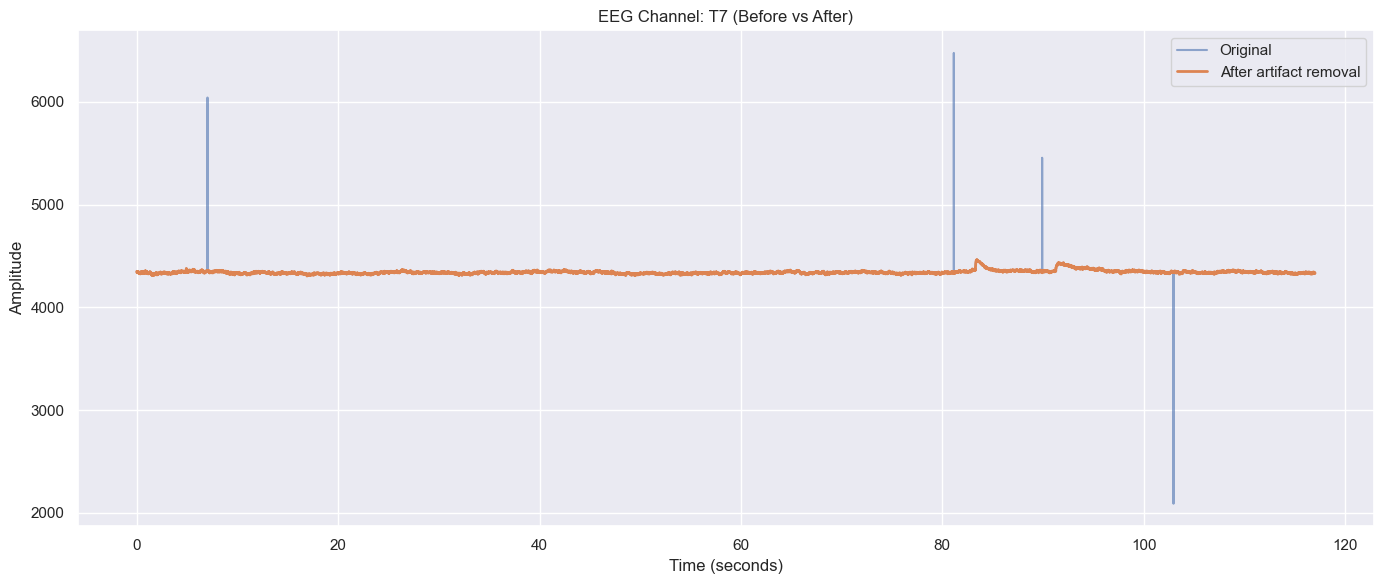

In [16]:
plt.figure(figsize=(14, 6))

# Before
plt.plot(t, eeg_df['T7'], 
         label="Original", 
         alpha=0.6)

# After
plt.plot(t, eeg_df_interp['T7'], 
         label="After artifact removal", 
         linewidth=2)

plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title(f"EEG Channel: T7 (Before vs After)")
plt.legend()
plt.tight_layout()
plt.show()


## apply bandBass filter

In [134]:
nyquist = sfreq/ 2
low = 8 / nyquist
high = 13 / nyquist
b,a=scipy.signal.butter(4,[low,high],btype='band')

In [135]:
band_filt_eeg=pd.DataFrame()
for ch in eeg_df_interp.columns:

    b_f_eeg=scipy.signal.filtfilt(b,a,eeg_df_interp[ch])
    band_filt_eeg[ch]=b_f_eeg


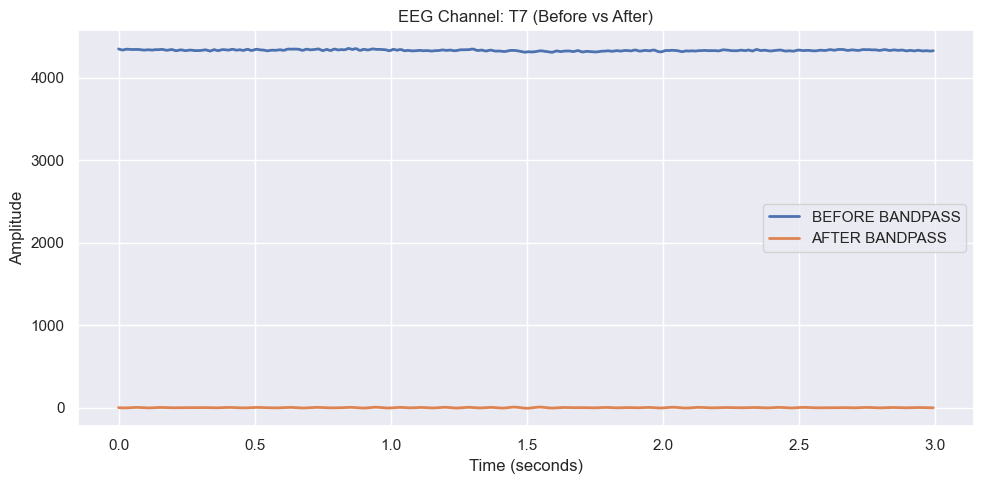

In [136]:
plt.figure(figsize=(10, 5))

plt.plot(t[:3*128], eeg_df_interp['T7'][:3*128], 
         label="BEFORE BANDPASS", 
         linewidth=2)
plt.plot(t[:3*128], band_filt_eeg['T7'][:3*128], 
         label="AFTER BANDPASS", 
         linewidth=2)

plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title(f"EEG Channel: T7 (Before vs After)")
plt.legend()
plt.tight_layout()
plt.show()


## normalize using Zscore

In [137]:
eeg_norm=band_filt_eeg.apply(scipy.stats.zscore)

In [21]:
# eeg_norm = (band_filt_eeg - band_filt_eeg.mean()) / band_filt_eeg.std()


In [138]:
print(eeg_norm.mean())
print(eeg_norm.std())

AF3   -1.608267e-18
F7     1.747601e-17
F3    -1.838019e-17
FC5   -3.409230e-19
T7     1.618643e-17
P7    -3.498166e-18
O1     1.430394e-18
O2    -2.377567e-17
P8     7.411369e-20
T8    -7.129737e-18
FC6    8.760238e-18
F4    -3.142420e-18
F8    -3.861323e-18
AF4    5.084199e-18
dtype: float64
AF3    1.000033
F7     1.000033
F3     1.000033
FC5    1.000033
T7     1.000033
P7     1.000033
O1     1.000033
O2     1.000033
P8     1.000033
T8     1.000033
FC6    1.000033
F4     1.000033
F8     1.000033
AF4    1.000033
dtype: float64


## feature extraction

In [139]:
features={}

for ch in eeg_norm.columns:
    features[ch]=helper_functions.extract_features(eeg_norm[ch])
    


In [24]:
comparison_df = pd.DataFrame(features).T
comparison_df

,Mean,Std,var,RMS,Peak,Skewness,Kurtosis,Crest Factor,Shannon Entropy,Zero-Crossing Rate
AF3,-1.608267e-18,1.000033,1.000067,1.0,21.560692,0.002102,202.499040,21.560692,0.214764,0.162561
F7,1.747601e-17,1.000033,1.000067,1.0,5.721310,0.000462,0.844901,5.721310,1.366476,0.160825
F3,-1.838019e-17,1.000033,1.000067,1.0,5.422855,0.000047,1.148886,5.422855,1.382741,0.161292
FC5,-3.409230e-19,1.000033,1.000067,1.0,25.106107,-0.002703,211.588183,25.106107,0.076621,0.162227
T7,1.618643e-17,1.000033,1.000067,1.0,4.985529,0.000266,0.153826,4.985529,1.471453,0.163095
P7,-3.498166e-18,1.000033,1.000067,1.0,31.518822,0.008434,411.111762,31.518822,0.053362,0.163763
O1,1.430394e-18,1.000033,1.000067,1.0,25.486862,0.001823,268.443712,25.486862,0.062158,0.163496
O2,-2.377567e-17,1.000033,1.000067,1.0,4.733298,0.000117,0.631459,4.733298,1.501424,0.168836
P8,7.411369e-20,1.000033,1.000067,1.0,23.741109,0.000709,236.804680,23.741109,0.663127,0.167368
T8,-7.129737e-18,1.000033,1.000067,1.0,6.563792,0.000366,1.269233,6.563792,1.241299,0.166233


<Axes: >

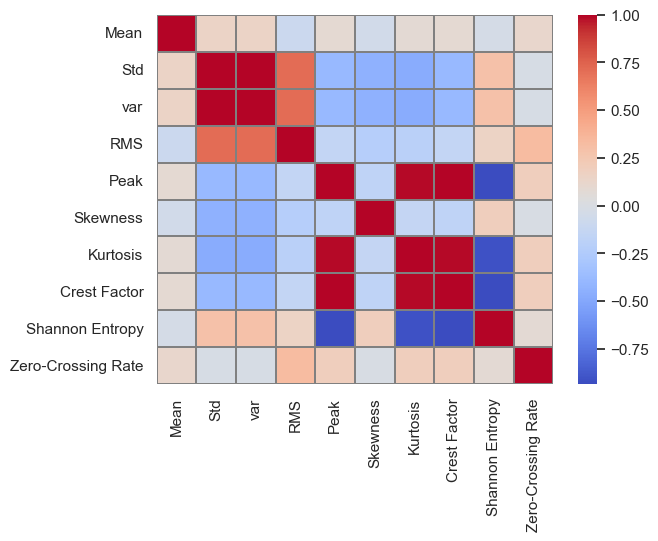

In [25]:
corr=comparison_df.corr()

sns.heatmap(corr,cmap="coolwarm",annot=False,linewidths=0.003,linecolor='grey')

## spectiral Features 

In [26]:
spec_features={}
for ch in eeg_norm.columns:
    spec_features[ch]=helper_functions.spectral_features(eeg_norm[ch],sfreq)

spec_comparisson_df=pd.DataFrame(spec_features).T
spec_comparisson_df

,delta_abs,delta_rel,theta_abs,theta_rel,alpha_abs,alpha_rel,beta_abs,beta_rel,gamma_abs,gamma_rel,spectral_centroid,spectral_entropy
AF3,820.308419,7.311114e-06,1.271619e+06,0.011333,1.089782e+08,0.971283,1.949474e+06,0.017375,15.941372,1.420797e-07,10.469665,8.798123
F7,7666.371872,6.832761e-05,1.437931e+06,0.012816,1.092902e+08,0.974064,1.463340e+06,0.013042,152.617012,1.360220e-06,10.160997,8.632828
F3,648.292868,5.778001e-06,1.858454e+06,0.016564,1.090130e+08,0.971594,1.327673e+06,0.011833,241.427301,2.151755e-06,10.232276,8.649116
FC5,55.262721,4.925367e-07,1.089264e+06,0.009708,1.093288e+08,0.974408,1.781925e+06,0.015882,121.534758,1.083196e-06,10.429795,8.781554
T7,6747.074644,6.013425e-05,1.538322e+06,0.013711,1.093180e+08,0.974312,1.335623e+06,0.011904,551.767033,4.917701e-06,10.323489,8.661036
P7,4.573110,4.075849e-08,1.179923e+06,0.010516,1.091214e+08,0.972560,1.898892e+06,0.016924,0.535921,4.776475e-09,10.521274,8.937882
O1,269.752363,2.404206e-06,1.220357e+06,0.010877,1.089483e+08,0.971017,2.031225e+06,0.018104,35.549359,3.168386e-07,10.477011,8.809432
O2,514.993168,4.589949e-06,6.457389e+05,0.005755,1.095590e+08,0.976460,1.994932e+06,0.017780,3.274948,2.918844e-08,10.668301,8.581664
P8,261.859844,2.333863e-06,1.179930e+06,0.010516,1.091492e+08,0.972807,1.870788e+06,0.016674,1.680988,1.498204e-08,10.499317,8.785666
T8,3775.206929,3.364706e-05,1.110327e+06,0.009896,1.099592e+08,0.980026,1.126411e+06,0.010039,59.235045,5.279406e-07,10.383634,8.609641


<Axes: >

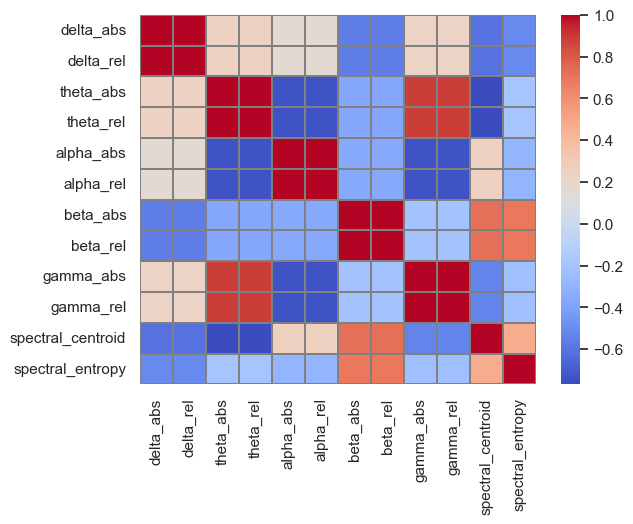

In [27]:
from cv2 import line


corr=spec_comparisson_df.corr()

sns.heatmap(corr,cmap="coolwarm",annot=False,linewidths=0.003,linecolor='grey')

In [56]:
import importlib
import helper_functions

importlib.reload(helper_functions)


<module 'helper_functions' from 'c:\\Users\\hana\\OneDrive\\Documents\\GitHub\\EEG-Eye-state-classifier\\helper_functions.py'>

In [ ]:
helper_functions.extract_features(eeg_df)

In [69]:
X = eeg_norm.drop(columns=['eyeDetection'])
y = eeg_norm['eyeDetection']


In [140]:
features={}

for ch in X.columns:
    features[ch]=helper_functions.features(eeg_norm[ch])
    
features_df = pd.DataFrame(features).T
features_df


,delta_abs,delta_rel,theta_abs,theta_rel,alpha_abs,alpha_rel,beta_abs,beta_rel,gamma_abs,gamma_rel,...,mean,std,var,rms,peak,skewness,kurtosis,crest_factor,shannon_entropy,zcr
AF3,820.308419,7.311114e-06,1.271619e+06,0.011333,1.089782e+08,0.971283,1.949474e+06,0.017375,15.941372,1.420797e-07,...,-1.608267e-18,1.0,1.0,1.0,21.560692,0.002102,202.499040,21.560692,0.214764,0.162561
F7,7666.371872,6.832761e-05,1.437931e+06,0.012816,1.092902e+08,0.974064,1.463340e+06,0.013042,152.617012,1.360220e-06,...,1.747601e-17,1.0,1.0,1.0,5.721310,0.000462,0.844901,5.721310,1.366476,0.160825
F3,648.292868,5.778001e-06,1.858454e+06,0.016564,1.090130e+08,0.971594,1.327673e+06,0.011833,241.427301,2.151755e-06,...,-1.838019e-17,1.0,1.0,1.0,5.422855,0.000047,1.148886,5.422855,1.382741,0.161292
FC5,55.262721,4.925367e-07,1.089264e+06,0.009708,1.093288e+08,0.974408,1.781925e+06,0.015882,121.534758,1.083196e-06,...,-3.409230e-19,1.0,1.0,1.0,25.106107,-0.002703,211.588183,25.106107,0.076621,0.162227
T7,6747.074644,6.013425e-05,1.538322e+06,0.013711,1.093180e+08,0.974312,1.335623e+06,0.011904,551.767033,4.917701e-06,...,1.618643e-17,1.0,1.0,1.0,4.985529,0.000266,0.153826,4.985529,1.471453,0.163095
P7,4.573110,4.075849e-08,1.179923e+06,0.010516,1.091214e+08,0.972560,1.898892e+06,0.016924,0.535921,4.776475e-09,...,-3.498166e-18,1.0,1.0,1.0,31.518822,0.008434,411.111762,31.518822,0.053362,0.163763
O1,269.752363,2.404206e-06,1.220357e+06,0.010877,1.089483e+08,0.971017,2.031225e+06,0.018104,35.549359,3.168386e-07,...,1.430394e-18,1.0,1.0,1.0,25.486862,0.001823,268.443712,25.486862,0.062158,0.163496
O2,514.993168,4.589949e-06,6.457389e+05,0.005755,1.095590e+08,0.976460,1.994932e+06,0.017780,3.274948,2.918844e-08,...,-2.377567e-17,1.0,1.0,1.0,4.733298,0.000117,0.631459,4.733298,1.501424,0.168836
P8,261.859844,2.333863e-06,1.179930e+06,0.010516,1.091492e+08,0.972807,1.870788e+06,0.016674,1.680988,1.498204e-08,...,7.411369e-20,1.0,1.0,1.0,23.741109,0.000709,236.804680,23.741109,0.663127,0.167368
T8,3775.206929,3.364706e-05,1.110327e+06,0.009896,1.099592e+08,0.980026,1.126411e+06,0.010039,59.235045,5.279406e-07,...,-7.129737e-18,1.0,1.0,1.0,6.563792,0.000366,1.269233,6.563792,1.241299,0.166233


<Axes: >

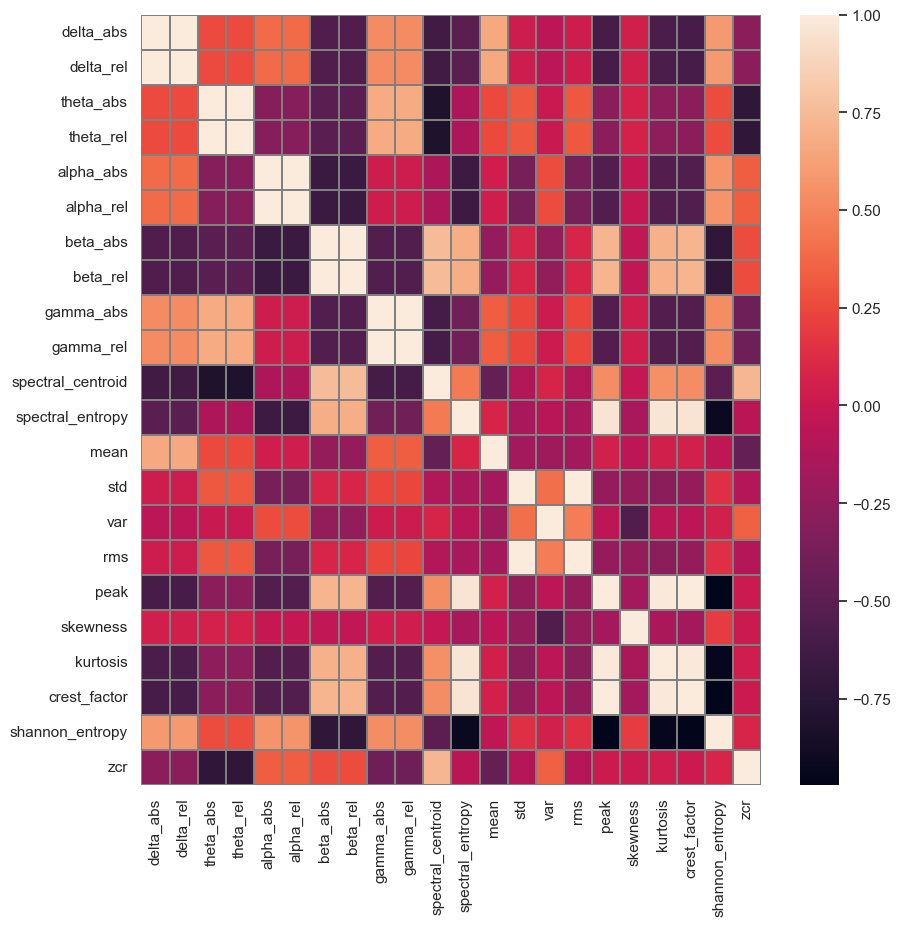

In [141]:
plt.figure(figsize=(10, 10))
corr=features_df.corr()

sns.heatmap(corr,annot=False,linewidths=0.003,linecolor='grey')

In [142]:
threshold = 0.8
upper_triangle = corr.where(
    np.triu(np.ones(corr.shape), k=1).astype(bool)
)

to_drop = [
    column for column in upper_triangle.columns
    if any(upper_triangle[column] > threshold)
]

features_reduced = features_df.drop(columns=to_drop)


In [143]:
features_df.shape

(14, 22)

In [144]:
to_drop

['delta_rel',
 'theta_rel',
 'alpha_rel',
 'beta_rel',
 'gamma_rel',
 'rms',
 'peak',
 'kurtosis',
 'crest_factor']

In [145]:
print(f"Original number of features: {X.shape[1]}")
print(f"Number of removed features: {len(to_drop)}")
print("Removed features:")
for f in to_drop:
    print("-", f)


Original number of features: 14
Number of removed features: 9
Removed features:
- delta_rel
- theta_rel
- alpha_rel
- beta_rel
- gamma_rel
- rms
- peak
- kurtosis
- crest_factor


<Axes: >

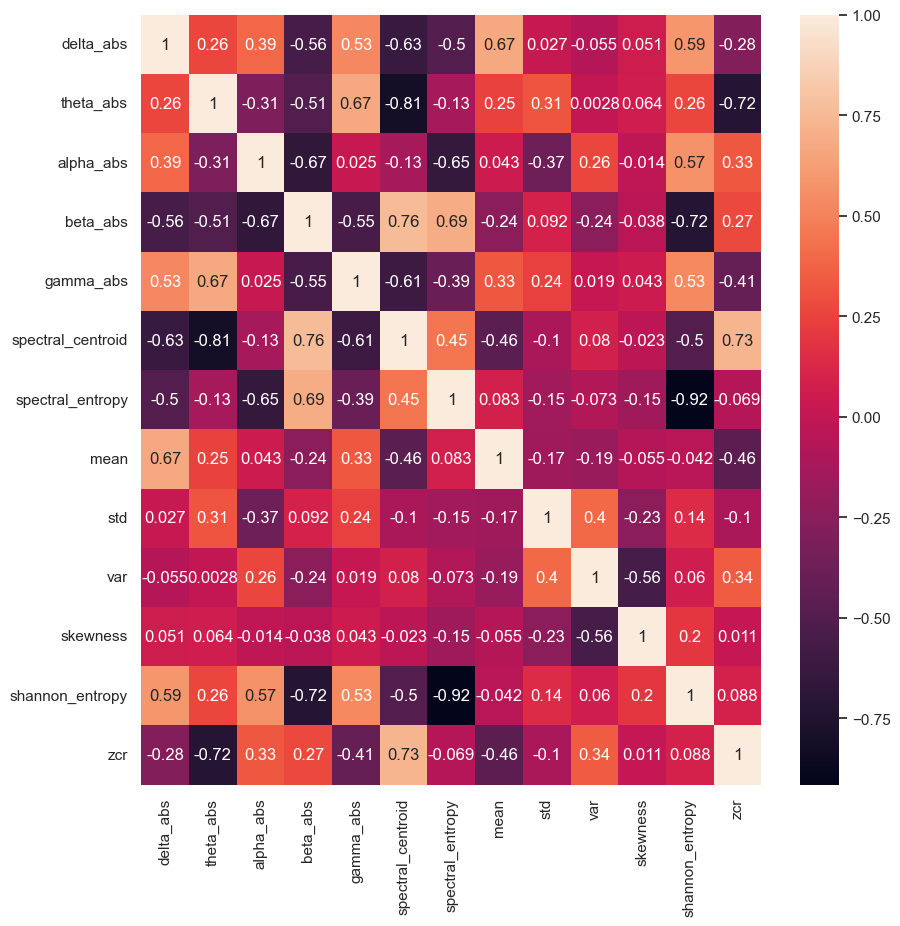

In [84]:
plt.figure(figsize=(10, 10))

sns.heatmap(features_reduced.corr(),annot=True)

In [86]:
from sklearn.decomposition import PCA
pca=PCA()

features_pca=pca.fit_transform(features_reduced)
features_pca

array([[ 4.71380242e+05,  1.21080297e+05,  2.17663372e+02,
        -7.64221104e+01,  1.99520620e-01, -5.81347015e-02,
        -4.75518309e-02,  2.36405365e-02,  1.97241527e-03,
        -7.30291898e-04,  3.72742127e-17, -2.29263784e-17,
         3.81465332e-18],
       [-1.26272051e+05,  1.85454692e+05,  6.15634023e+03,
        -1.71506676e+02, -6.77155014e-01,  4.31060100e-01,
         1.82101097e-02, -2.33243649e-02,  5.36302664e-04,
         7.09806911e-05, -4.36255143e-17, -1.84415641e-17,
        -3.91338991e-19],
       [-1.52870453e+05,  7.06338596e+05, -2.73432666e+03,
        -3.71200621e+01,  8.01742644e-01,  4.15113654e-01,
        -5.12965460e-03, -1.24229867e-02, -1.80550042e-03,
        -9.92250102e-04, -9.47921264e-17, -1.19531494e-17,
         5.83730419e-19],
       [ 1.69899159e+05, -1.84463781e+05, -1.46974668e+03,
         1.29126844e+02, -1.76707832e+00, -1.74229740e-01,
        -2.72630551e-02, -3.64896861e-02,  1.18434266e-03,
        -2.67300254e-04, -8.80999138e

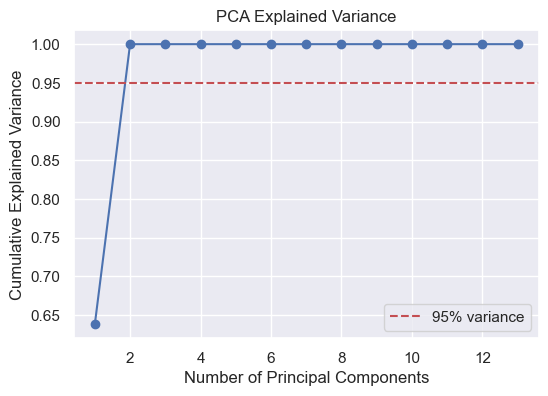

In [92]:
import matplotlib.pyplot as plt
import numpy as np

cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.95, color='r', linestyle='--', label='95% variance')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.legend()
plt.show()


In [88]:
n_components_95 = np.argmax(cum_var >= 0.95) + 1
print(f"Number of components to explain 95% variance: {n_components_95}")

Number of components to explain 95% variance: 2


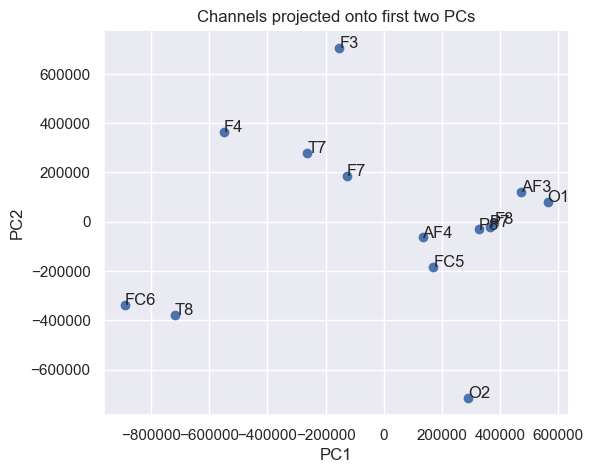

In [96]:
plt.figure(figsize=(6,5))
plt.scatter(features_pca[:,0], features_pca[:,1])

for i, ch in enumerate(features_df.index):
    plt.text(features_pca[i,0], features_pca[i,1], ch)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Channels projected onto first two PCs")
plt.grid(True)
plt.show()


In [94]:
print("Shape of PCA output:", features_pca.shape)

Shape of PCA output: (14, 13)


## eldonia f elsection elfat ma3koka🤩🤩🤩

## create widows

In [111]:
X_windows ,y_windows=helper_functions.create_windows(X,y,3,0.5)

X_windows.shape

(77, 384, 14)

In [125]:
y

0       -0.001310
1       -0.000275
2        0.000871
3        0.001956
4        0.002799
           ...   
14975    2.786276
14976    1.534155
14977    0.181201
14978   -0.917067
14979   -1.548354
Name: eyeDetection, Length: 14980, dtype: float64

In [158]:
win_sizes=[1,2,3]
diffrent_windows={}

for i in win_sizes:
    X_windows ,y_windows=helper_functions.create_windows(X,y,i,0.5)
    diffrent_windows[f"{i} sec windows"]=[X_windows,y_windows]
    print(f"created {X_windows.shape[0]} windows for {i} sec window size")
    # print(y_windows)
    label_zero_count=len([i for i in y_windows if i==0])
    print(f"label distribution of {i} sec window is {label_zero_count} eye closed and {(len(y_windows)-label_zero_count)} eye open")

created 233 windows for 1 sec window size
label distribution of 1 sec window is 129 eye closed and 104 eye open
created 116 windows for 2 sec window size
label distribution of 2 sec window is 65 eye closed and 51 eye open
created 77 windows for 3 sec window size
label distribution of 3 sec window is 43 eye closed and 34 eye open


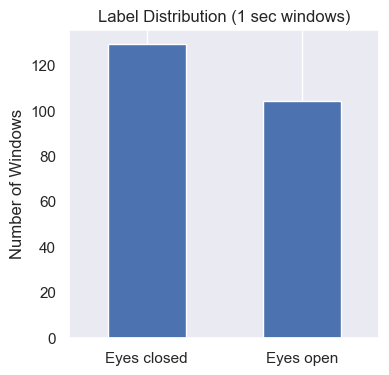

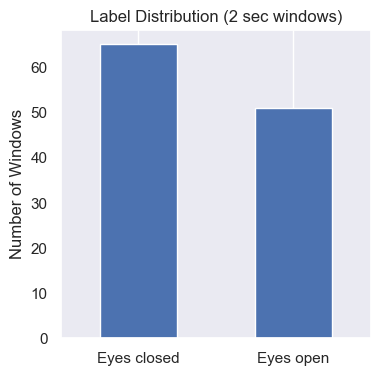

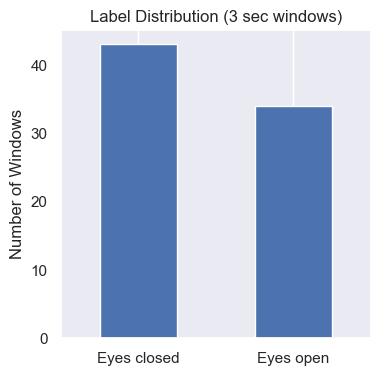

In [151]:
##label distribution
for i in win_sizes:
    
    y=diffrent_windows[f"{i} sec windows"][1]
    label_counts = pd.Series(y).value_counts().sort_index()

    plt.figure(figsize=(4,4))
    label_counts.plot(kind="bar")
    plt.xticks([0,1], ["Eyes closed", "Eyes open"], rotation=0)
    plt.ylabel("Number of Windows")
    plt.title(f"Label Distribution ({i} sec windows)")
    plt.grid(axis="y")
    plt.show()

## Extract features per window


In [159]:
importlib.reload(helper_functions)

<module 'helper_functions' from 'c:\\Users\\hana\\OneDrive\\Documents\\GitHub\\EEG-Eye-state-classifier\\helper_functions.py'>

In [163]:
X_1sec_window,y_1sec_window= diffrent_windows["1 sec windows"]

channel_names = eeg_df.columns.tolist()  

X_features = helper_functions.features_all_windows(
    X_1sec_window,
    channel_names,
    
)

print(X_features.shape)


(233, 182)


In [166]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_1sec_window, test_size=0.2, random_state=42, stratify=y_1sec_window
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [167]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
# regresor= LogisticRegression()
# regresor.fit(X_train,y_train)
